In [7]:
import numpy as np, scipy as sp
import time
import scipy.linalg, scipy.sparse.linalg
from flint import fmpq, fmpz, fmpq_mat
from mpmath import mp
from matplotlib import pyplot as p
from importlib import reload

Let $J$ be the random variable with $\mathbb P(J = j) = 1/j(j+1)$.

If we currently have $x$ active sites, then one step works like this:
* the rightmost active chip falls asleep with probability $q$.
* it moves left with probability $(1-q)/2$, and then randomly walks until it returns to the origin. This will wake up $J$ sites to the left of the chip, but $x - 1$ were already awake anyway, so the new number of awake sites is $L \wedge ((J+1) \vee x)$.
* it moves right with probability $(1-q)/2$, and then randomly walks until it returns to the origin. This wakes up $J$ sites to the left of the chip which were asleep at first, so the number of awake sites is $L \wedge (J + x)$.

Let $T(x) := \mathbb E_x[\text{expected time until we hit the origin}]$.
We can find it by solving a recurrence:
$$T(x) = 1 + qT(x-1) + \frac12 (1 - q) \sum {1 \over j(j+1)} T(L \wedge ((j+1) \vee x)) + \frac12 (1 - q) \sum {1 \over j(j+1)} T(L \wedge (j + x)).$$


In [21]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [150]:
%%cython
# we do this in an obvious way rather than writing efficient code
# but to speed things up a bit, let's use cython

import numpy as np

cimport numpy as np

def solve_time_recurrence(L, q): #(L, q, c, a):
    values = np.array([0.] * L + [0.])
    for x in range(L, 0, -1):
        subtotal = 0
        j = 1
        while j + x < L:
            subtotal += 1/(j*(j+1)) * values[j + x]
            j += 1
        subtotal += 1/j * values[L]
        total = 0.5 * (1-q) * subtotal
        
        subtotal = 0
        if False:
            j = 1
            while j < L:
                subtotal += 1/(j*(j+1)) * values[max(j+1, x)]
                j += 1
        else:
            subtotal = values[x] * (1 - 1/x)
            j = x
            while j < L:
                subtotal += 1/(j*(j+1)) * values[j+1]
                j += 1
        subtotal += 1/j * values[L]
        total += 0.5 * (1-q) * subtotal
        
        total += 1
        
        values[x-1] = (values[x] - total) / q
    
    return values

def solve_harmonic_recurrence(L, q): #(L, q, c, a):
    values = np.array([0.] * (L-1) + [1., 0.])
    for x in range(L-1, 0, -1):
        subtotal = 0
        j = 1
        while j + x < L:
            subtotal += 1/(j*(j+1)) * values[j + x]
            j += 1
        subtotal += 1/j * values[L]
        total = 0.5 * (1-q) * subtotal
        
        subtotal = 0
        j = 1
        while j < L:
            subtotal += 1/(j*(j+1)) * values[max(j+1, x)]
            j += 1
        subtotal += 1/j * values[L]
        total += 0.5 * (1-q) * subtotal
        
        values[x-1] = (values[x] - total) / q
    
    return values

L = 1000    q = 0.775477


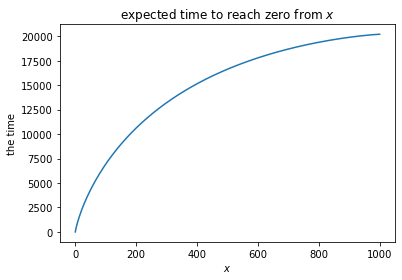

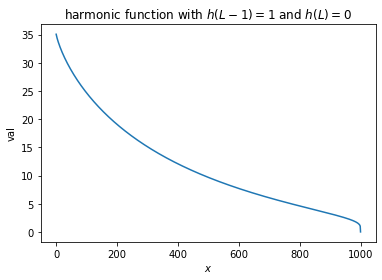

In [158]:
def plot(L, q):
    print("L = %d    q = %f" % (L, q))
    z = solve_time_recurrence(L, q)
    p.title("expected time to reach zero from $x$")
    p.xlabel("$x$")
    p.ylabel("the time")
    p.plot(z - z[0])
    p.show()
    p.title("harmonic function with $h(L-1) = 1$ and $h(L) = 0$")
    p.xlabel("$x$")
    p.ylabel("val")
    p.plot(solve_harmonic_recurrence(L, q))
    p.show()

def criticalq(L):
    return 1 - 1/(1 + 0.5 * np.log(L))

plot(1000, criticalq(1000))

In [112]:
def eval(L):
    q = 1 - 1/(1 + 1.2 * 0.5 * np.log(L))
    z = -solve_time_recurrence(L, q)[0]
    print("L = %6d    q = %6f    T / L = %6f    T/L/log L = %6f" % (L, q, z/L, z/L/np.log(L)))

print("q/(1-q) = 1.2 * 0.5 * log L")

eval(100)
eval(1000)
eval(10000)

q/(1-q) = 1.2 * 0.5 * log L
L =    100    q = 0.734262    T / L = 7.188469    T/L/log L = 1.560956
L =   1000    q = 0.805623    T / L = 7.313144    T/L/log L = 1.058686
L =  10000    q = 0.846772    T / L = 7.294743    T/L/log L = 0.792017


In [111]:
def eval(L):
    q = 1 - 1/(1 + 0.5 * np.log(L))
    z = -solve_time_recurrence(L, q)[0]
    print("L = %6d    q = %6f    T / L = %6f    T/L/log L = %6f" % (L, q, z/L, z/L/np.log(L)))

print("q/(1-q) = 0.5 * log L")

eval(100)
eval(1000)
eval(10000)

q/(1-q) = 0.5 * log L
L =    100    q = 0.697207    T / L = 15.058336    T/L/log L = 3.269876
L =   1000    q = 0.775477    T / L = 20.201433    T/L/log L = 2.924457
L =  10000    q = 0.821593    T / L = 25.410094    T/L/log L = 2.758866


In [113]:
def eval(L):
    q = 1 - 1/(1 + 0.8 * 0.5 * np.log(L))
    z = -solve_time_recurrence(L, q)[0]
    print("L = %6d    q = %6f    T / L = %6f    T/L/log L = %6f" % (L, q, z/L, z/L/np.log(L)))

print("q/(1-q) = 0.8 * 0.5 * log L")

eval(100)
eval(1000)
eval(10000)

q/(1-q) = 0.8 * 0.5 * log L
L =    100    q = 0.648144    T / L = 70.238395    T/L/log L = 15.252074
L =   1000    q = 0.734262    T / L = 403.890609    T/L/log L = 58.469154
L =  10000    q = 0.786513    T / L = 5158.183597    T/L/log L = 560.042668


In [126]:
def make_plot(L):
    def what(q):
        return -solve_time_recurrence(L, q)[0]
    x = np.linspace(0.5, 2, 11)
    q = 1 - 1/(1 + x * 0.5 * np.log(L))
    y = np.array([what(_) for _ in q])
    p.title("expected time to reach zero from $L = %d$" % L)
    p.xlabel("$c$, where $q/(1-q) = c \\times \\frac{1}{2}\\log L$")
    p.ylim([0, L * 100])
    p.plot(x, y)

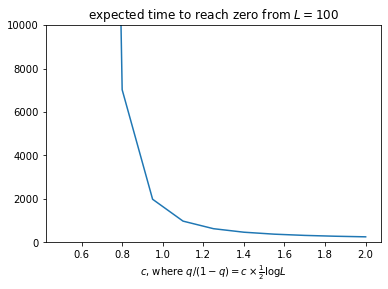

In [127]:
make_plot(100)

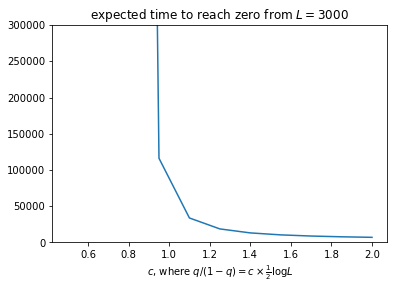

In [128]:
make_plot(3000)

In [ ]:
a
